# Introdução ao Keras

Vamos usar Keras no conjunto de dados MNIST novamente, desta vez usando uma Rede Neural Convolucional que é mais adequada para o processamento de imagens. As CNNs são menos sensíveis a onde na imagem o padrão é o que procuramos.

Com um perceptron multicamada, atingimos cerca de 97% de precisão. Vamos ver se podemos vencer isso.

Como antes, começaremos importando as coisas que precisamos, incluindo os novos tipos de camadas de que falamos:

In [7]:
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Carregaremos nosso conjunto de dados brutos exatamente como antes:

In [3]:
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

Precisamos moldar os dados de maneira diferente antes. Como estamos tratando os dados como imagens 2D de 28x28 pixels em vez de um fluxo achatado de 784 pixels, precisamos moldá-lo de acordo. Dependendo do formato de dados para o qual Keras está configurado, pode ser 1x28x28 ou 28x28x1 (o "1" indica um único canal de cor, pois é apenas escala de cinza. Se estivéssemos lidando com imagens coloridas, seria 3 em vez de 1 teríamos canais de cores vermelho, verde e azul)

In [4]:
from tensorflow.keras import backend as K

if K.image_data_format() == 'channels_first':
    train_images = mnist_train_images.reshape(mnist_train_images.shape[0], 1, 28, 28)
    test_images = mnist_test_images.reshape(mnist_test_images.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    train_images = mnist_train_images.reshape(mnist_train_images.shape[0], 28, 28, 1)
    test_images = mnist_test_images.reshape(mnist_test_images.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)
    
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

Como antes, precisamos converter nossos rótulos de treino e de teste para serem categóricos em um formato "one-hot":

In [5]:
train_labels = tensorflow.keras.utils.to_categorical(mnist_train_labels, 10)
test_labels = tensorflow.keras.utils.to_categorical(mnist_test_labels, 10)

Como verificação de integridade, vamos imprimir uma das imagens de treinamento com o rótulo:

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


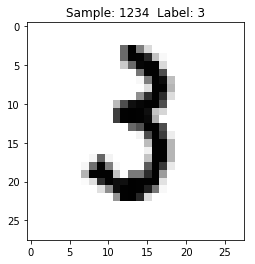

In [8]:
def display_sample(num):
    #Print the one-hot array of this sample's label 
    print(train_labels[num])  
    #Print the label converted back to a number
    label = train_labels[num].argmax(axis=0)
    #Reshape the 768 values to a 28x28 image
    image = train_images[num].reshape([28,28])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(1234)

A configuração de uma rede neural convolucional envolve mais camadas. Nem todos estes são estritamente necessários; você pode executar sem pooling e dropout, mas essas etapas extras ajudam a evitar overfitting e ajudam as coisas a serem executadas mais rapidamente.

Começaremos com uma convolução 2D da imagem - ela é configurada para tirar 32 janelas ou "filtros" de cada imagem, cada filtro com tamanho 3x3.

Em seguida, executamos uma segunda convolução em cima disso com 64 janelas 3x3 - essa topologia é exatamente o que é recomendado nos exemplos do próprio Keras. Mais uma vez, você quer reutilizar pesquisas anteriores sempre que possível enquanto ajusta as CNNs, já que é difícil fazer isso.

Em seguida, aplicamos uma camada MaxPooling2D que leva o máximo de cada resultado 2x2 para destilar os resultados em algo mais gerenciável.

Um filtro de dropout é então aplicado para evitar overfitting.

Em seguida, nivelamos a camada 2D que temos neste estágio em uma camada 1D. Então, neste ponto, podemos apenas fingir que temos um perceptron multicamada tradicional ...

... e alimentar isso em uma camada oculta e plana de 128 unidades.

Em seguida, aplicamos o abandono novamente para evitar o overfitting.

E finalmente, nós alimentamos isso em nossas 10 unidades finais onde softmax é aplicado para escolher nossa categoria de 0-9.

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
# 64 3x3 kernels
model.add(Conv2D(64, (3, 3), activation='relu'))
# Reduce by taking the max of each 2x2 block
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout to avoid overfitting
model.add(Dropout(0.25))
# Flatten the results to one dimension for passing into our final layer
model.add(Flatten())
# A hidden layer to learn with
model.add(Dense(128, activation='relu'))
# Another dropout
model.add(Dropout(0.5))
# Final categorization from 0-9 with softmax
model.add(Dense(10, activation='softmax'))

Vamos verificar novamente a descrição do modelo:

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

Ainda estamos fazendo várias categorizações, então categorical_crossentropy ainda é a função de perda correta a ser usada. Usaremos o otimizador Adam, embora o exemplo fornecido com o Keras use o RMSProp. Você pode querer tentar os dois se você tiver tempo.

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

E agora nós treinamos nosso modelo ... para tornar as coisas um pouco mais rápidas, usaremos lotes de 32.

## Aviso

Isso pode levar horas para ser executado, e a CPU do seu computador será excedida durante esse tempo! Não execute o próximo bloco, a menos que você possa dedicar seu computador por um longo tempo. Ele irá imprimir o progresso conforme cada época é executada, mas cada época pode levar cerca de 20 minutos.

In [12]:
history = model.fit(train_images, train_labels,
                    batch_size=32,
                    epochs=10,
                    verbose=2,
                    validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 113s - loss: 0.1884 - acc: 0.9428 - val_loss: 0.0457 - val_acc: 0.9841
Epoch 2/10
 - 117s - loss: 0.0809 - acc: 0.9760 - val_loss: 0.0319 - val_acc: 0.9895
Epoch 3/10
 - 130s - loss: 0.0604 - acc: 0.9811 - val_loss: 0.0310 - val_acc: 0.9897
Epoch 4/10
 - 104s - loss: 0.0480 - acc: 0.9851 - val_loss: 0.0344 - val_acc: 0.9895
Epoch 5/10
 - 100s - loss: 0.0425 - acc: 0.9868 - val_loss: 0.0323 - val_acc: 0.9901
Epoch 6/10
 - 99s - loss: 0.0360 - acc: 0.9892 - val_loss: 0.0317 - val_acc: 0.9904
Epoch 7/10
 - 99s - loss: 0.0307 - acc: 0.9908 - val_loss: 0.0266 - val_acc: 0.9917
Epoch 8/10
 - 99s - loss: 0.0284 - acc: 0.9909 - val_loss: 0.0332 - val_acc: 0.9914
Epoch 9/10
 - 98s - loss: 0.0257 - acc: 0.9920 - val_loss: 0.0309 - val_acc: 0.9919
Epoch 10/10
 - 99s - loss: 0.0247 - acc: 0.9924 - val_loss: 0.0331 - val_acc: 0.9914


Valeu a pena esperar?

In [10]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.034049834153382426
Test accuracy: 0.9918


Mais de 99%! E isso é com apenas 10 épocas! Ele teve um custo significativo em termos de poder de computação, mas quando você começa a distribuir coisas em vários computadores, cada um com várias GPUs, esse custo começa a parecer menos ruim. Se você está construindo algo em que a vida e a morte estão em jogo, como um carro autônomo, cada fração de um percentual é importante.